# Reference
[official CBAM](https://github.com/Jongchan/attention-module)

[CBAM: Convolutional Block Attention Module](https://arxiv.org/pdf/1807.06521.pdf)

[Tiny Imagenet loader](https://gist.github.com/bveliqi/a847f955f2ec13d74d22c088c6f771b4)

[Pytorch Doc](https://pytorch.org/docs/stable/nn.html)

[Pytorch DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[vision/torchvision/models/resnet.py](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

[pytorch/example/imagenet/main.py](https://github.com/pytorch/examples/blob/master/imagenet/main.py)

# Import

In [1]:
from __future__ import print_function

import argparse
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.autograd import Variable
from IPython.display import HTML
from PIL import ImageFile

%matplotlib inline

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Config

In [3]:
resnet_depth=50
seed = 2018
workers = 1
ngpu = 0
batch_size = 32
image_size = 64
num_channels = 3
num_epochs = 30
epoch = 0
decay_epoch = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
momentum = 0.9
sample_interval = 50
weight_decay = 0.0001
resume = None


torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

In [4]:
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

In [5]:
cuda = torch.cuda.is_available() and ngpu > 0
print(cuda)
device = 'cuda:0' if cuda else 'cpu'
print(device)

False
cpu


# Model

## CBAM

In [6]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super().__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes) if bn else None
        self.relu = nn.ReLU() if relu else None
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x    

In [7]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, dim=1)[0].unsqueeze(1), torch.mean(x, dim=1).unsqueeze(1)), dim=1)

In [8]:
class SpatialGate(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, padding=(kernel_size-1)//2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)
        return x * scale

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max']):
        super().__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels//reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = self.avg_pool(x)
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = self.max_pool(x)
                channel_att_raw = self.mlp(max_pool)
                
            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw
        
        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

In [10]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

## ResNet

In [11]:
# conv3x3 with pad 1
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [12]:
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [13]:
class BasicBlock(nn.Module):
    expansion = 1
        
    def __init__(self, in_planes, planes, stride=1, downsample=None, use_cbam=False):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        if use_cbam:
            self.cbam = CBAM(planes, 16)
        else:
            self.cbam = None
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(x)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        if self.cbam is not None:
            out = self.cbam(out)
        out += residual
        out = self.relu(out)
        return out

In [14]:
class BottleNeck(nn.Module):
    expansion = 4
    
    def __init__(self, in_planes, planes, stride=1, downsample=None, use_cbam=False):
        super().__init__()
        self.conv1 = conv1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        if use_cbam:
            self.cbam = CBAM(planes * 4, 16)
        else:
            self.cbam = None
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(residual)
        if self.cbam is not None:
            out = self.cbam(out)
        out += residual
        out = self.relu(out)
        return out

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                # The official code set bn.weight in spatial gate to 0, but there is no reason yet. 12/27/2018
        
        
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BottleNeck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=True))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=True))
        
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [16]:
assert resnet_depth in [18,34,50,101], 'ResNet_Depth should be 18 or 34 or 50 or 101'
# num_classes=200 with tiny imagenet
if resnet_depth == 18:
    model = ResNet(BasicBlock,[2,2,2,2], num_classes=200, zero_init_residual=True)
elif resnet_depth == 34:
    model = ResNet(BasicBlock,[3,4,6,3], num_classes=200, zero_init_residual=True)
elif resnet_depth == 50:
    model = ResNet(BottleNeck,[3,4,6,3], num_classes=200, zero_init_residual=True)
elif resnet_depth == 101:
    model = ResNet(BottleNeck,[3,4,23,3], num_classes=200, zero_init_residual=True)
    
if cuda:
    #model = torch.nn.DataParallel(model, device_ids=list(range(args.ngpu)))
    model = nn.DataParallel(model)
    model = model.cuda()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 

In [17]:
if cuda:
    model = torch.nn.parallel.DistributedDataParallel(model)
    model = model.cuda()

cudnn.benchmark = True

# Loss Function

In [18]:
criterion = nn.CrossEntropyLoss()

if cuda:
    criterion = criterion.cuda()

# Optimizer

In [19]:

optimizer = torch.optim.SGD(model.parameters(), lr = lr,
                            momentum = momentum,
                            weight_decay = weight_decay)

# CheckPoint

In [20]:
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint'{}'".format(resume))
        checkpoint = torch.load(resume)
        epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        if 'optimizer' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

# Evaluate

In [21]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [54]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# Data Loading

In [22]:
train_dir = 'data/tiny-imagenet-200/train'
val_dir = 'data/tiny-imagenet-200/test'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
print(train_dir)

data/tiny-imagenet-200/train


In [23]:
train_dataset = dset.ImageFolder(
        root = train_dir,
        transform = transforms.Compose([
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]))

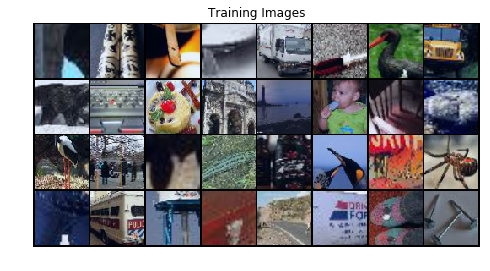

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=workers, pin_memory=True)
train_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Validate

In [27]:
val_dataset = dset.ImageFolder(
        root = val_dir,
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
        ]))

In [49]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers, pin_memory=True)

In [61]:
def validate(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for i, (input,target) in enumerate(val_loader):
            if cuda:
                input = input.cuda()
                target = target.cuda()
            
            output = model(input)
            
            print(output.shape)
            print(target.shape)
            
            loss = criterion(output, target)

            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            losses.update(loss.item(), input.size(0))

            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))
            
            batch_time.update(time.time() - end)
            end = time.time()

            if i % sample_interval == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       top1=top1, top5=top5))
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))
    return top1.avg

In [62]:
validate(val_loader, model, criterion, 0)

torch.Size([32, 200])
torch.Size([32])
tensor([[ 14, 155,  14,  14, 155, 155, 155,  14, 155, 155, 155, 155, 155, 155,
          14, 155,  14, 155,  77, 155, 155, 155, 155,  14, 155, 155, 155, 155,
          14,  14, 155, 155],
        [155,  14, 155, 155,  14,  75,  77, 155,  14,  14,  14,  77,  77,  14,
         155,  77, 155,  14, 155,  77,  14,  14,  77, 155,  73,  14,  14,  77,
         155, 155,  14,  14],
        [171,  73,  75,  73,  75,  77,  14,  73,  77,  75,  75,  46,  46,  77,
          75, 103, 171,  77,  98,  14,  77, 103,  14, 171,  75, 103,  77,  14,
         171,  75,  75, 103],
        [ 73, 103, 171, 171, 103,  98,  46, 171,  75,  77, 103,  14,  75,  75,
         171,  14,  75,  75,  14,  75,  98, 171,  98,  75, 103,  75,  75,  98,
          75,  77, 171, 171],
        [ 75,  77,  73,  75,  73,  14,  98,  75,  46,  46, 171,  98,  98,  73,
          73,  46,  73,  46,  46,  46,  75,  73,  75, 103,  46, 171,  98,  71,
          73,  46, 103,  73]])


TypeError: 'NoneType' object is not iterable

In [88]:
output = torch.randint(0,201,(32,200))
target = torch.randint(0,201,(32,))
print(output)
a, pred = output.topk(5, 1, True, True)
pred = pred.t()
print(pred.shape)
z = target.view(1,-1).expand_as(pred)
print(z.shape)
print(z)
print(pred)
correct = 1-pred.eq(z)
print(correct)
correct_k = correct[:1].view(-1).float().sum(0, keepdim=True)
print(correct_k)

tensor([[ 46,   9, 113,  ..., 122,  80, 141],
        [184, 167,  42,  ..., 197,  79, 189],
        [189, 162, 124,  ..., 136, 141, 195],
        ...,
        [  5, 190,  80,  ...,   1,  27,  18],
        [109, 132,  46,  ..., 115,  97, 147],
        [164, 135, 122,  ...,  70, 199,  38]])
torch.Size([5, 32])
torch.Size([5, 32])
tensor([[147, 109,  70, 162, 104,  79,  90,  25, 128,  87, 200, 159, 196, 118,
         160,  90,  61, 195, 153,  52,  27, 108, 150,  76, 131, 198, 122, 176,
          93, 107, 107,  30],
        [147, 109,  70, 162, 104,  79,  90,  25, 128,  87, 200, 159, 196, 118,
         160,  90,  61, 195, 153,  52,  27, 108, 150,  76, 131, 198, 122, 176,
          93, 107, 107,  30],
        [147, 109,  70, 162, 104,  79,  90,  25, 128,  87, 200, 159, 196, 118,
         160,  90,  61, 195, 153,  52,  27, 108, 150,  76, 131, 198, 122, 176,
          93, 107, 107,  30],
        [147, 109,  70, 162, 104,  79,  90,  25, 128,  87, 200, 159, 196, 118,
         160,  90,  61, 195